# Классификация фотографий знаменитостей
---

## Загрузка инструментария и данных

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [39]:
import os
import time
import random

import matplotlib.pyplot as plt
import numpy as np
from copy import copy
from tqdm import tqdm

import torch
import torchvision
import torchvision.datasets as D
import torchvision.transforms as T
import torchvision.models as M
import sklearn.model_selection as ms
from torch.nn import functional as F
from torch.utils.data import DataLoader
from PIL import Image

print(torch.__version__)
print(torchvision.__version__)

2.3.0+cu121
0.18.0+cu121


Узнаем текущую директорию

In [3]:
current_directory = os.getcwd()
print(current_directory)

/content


Распакуем данные в текущую директорию

In [4]:
data_path = "/content/drive/MyDrive/data.zip"

import zipfile

with zipfile.ZipFile(data_path, 'r') as zipp:
    zipp.extractall(current_directory)

## Подготовка данных

Фотографии раскиданы по соответствующим папкам:

In [5]:
!ls /content/data/train

bill_gates  elon_musk  jeff_bezos  mark_zuckerberg  steve_jobs


Выведем общее число изображений в выборках

In [6]:
!find /content/data/train -type f | wc -l
!find /content/data/valid -type f | wc -l

3000
914


Также посмотрим на соотношение изображений в выборках

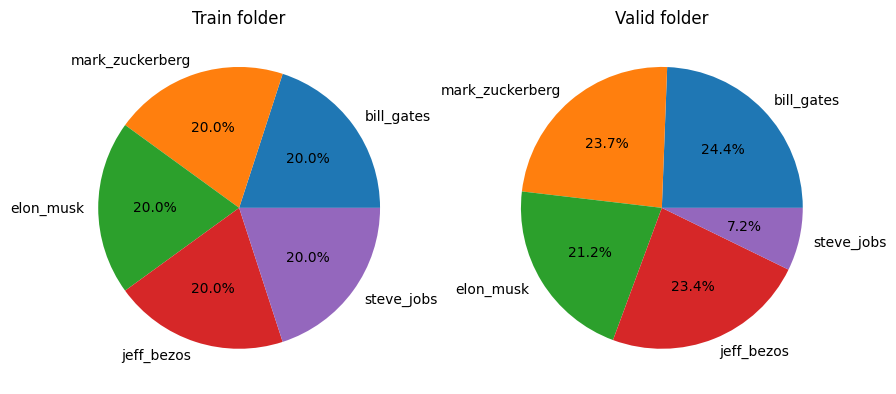

In [10]:
train_folder = '/content/data/train'
valid_folder = '/content/data/valid'

def count_images_in_folders(path_to_folder):
    subfolders = os.listdir(path_to_folder)
    file_counts = []

    for folder in subfolders:
        folder_path = os.path.join(path_to_folder, folder)
        files = os.listdir(folder_path)
        image_files = [f for f in files if f.endswith('.jpg') or f.endswith('.png')]
        file_counts.append(len(image_files))

    return file_counts

counts1 = count_images_in_folders(train_folder)
counts2 = count_images_in_folders(valid_folder)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.pie(counts1, labels=os.listdir(train_folder), autopct='%1.1f%%')
plt.title('Train folder')

plt.subplot(1, 2, 2)
plt.pie(counts2, labels=os.listdir(valid_folder), autopct='%1.1f%%')
plt.title('Valid folder')

plt.show()

Стив Джобс в валидационной выборке недопредставлен.

Скормим ссылки датасетам

In [11]:
train_dataset = D.ImageFolder("/content/data/train")
valid_dataset = D.ImageFolder("/content/data/valid")

Посмотрим на примеры из обучения и валидации

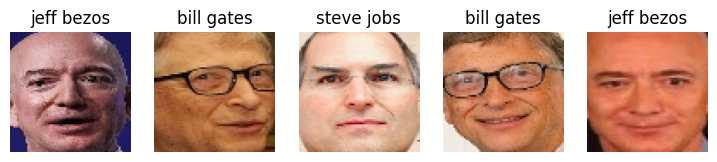

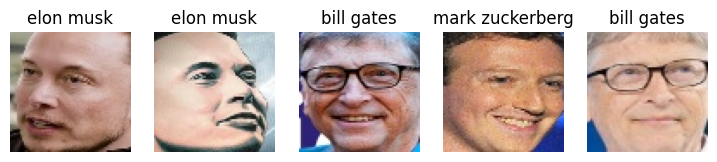

In [12]:
def plot_samples(dataset, num_samples=5):
    _, axes = plt.subplots(1, num_samples, figsize=(9, 3))

    for i in range(num_samples):
        random_image, random_class = random.choice(dataset)
        random_label = dataset.classes[random_class]
        axes[i].imshow(random_image)
        axes[i].set_title(random_label.replace("_", " "))
        axes[i].axis("off")

    plt.show()

plot_samples(train_dataset)
plot_samples(valid_dataset)

Определим также даталоадеры для обучения и валидации

In [62]:
BATCH_SIZE = 16

# normalize = T.Normalize(
#     mean=[0.485, 0.456, 0.406],
#     std=[0.229, 0.224, 0.225]
# )

train_dataset.transform = T.Compose([
    T.Resize(size=(256, 256)),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    # normalize
])

valid_dataset.transform = T.Compose([
    T.Resize(size=(256, 256)),
    T.ToTensor(),
    # normalize
])

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE,
    shuffle=True, num_workers=os.cpu_count()
)

valid_loader = DataLoader(
    valid_dataset, batch_size=BATCH_SIZE,
    shuffle=True, num_workers=os.cpu_count()
)

## Обучение модели

In [63]:
model = M.resnet34(weights=M.ResNet34_Weights.IMAGENET1K_V1)

total_params = sum(p.numel() for p in model.parameters())
print("Total parameters: ", total_params)

model.fc = torch.nn.Linear(512, len(train_dataset.classes))

criterion = torch.nn.CrossEntropyLoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)
model = model.to(device)
criterion = criterion.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

Total parameters:  21797672
Device: cuda


Для удобства создадим словарь даталоадеров:

In [64]:
dataloaders = {
    'train': train_loader,
    'valid': valid_loader
}

Напишем трейнер

In [16]:
def train_model(
    model, device, dataloaders, criterion,
    optimizer, batch_size, num_epochs=1, rep_freq=None):
    since = time.time()

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # На каждой эпохе происходит обучение и валидая
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            current_loss = 0.0
            current_corrects = 0
            batch = 0

            # Проходим по данным
            for inputs, labels in dataloaders[phase]:
                batch += 1
                inputs = inputs.to(device)
                labels = labels.to(device)

                # обнуляем градиенты
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    # Получаем прогноз модели и считаем лосс
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)

                    labels = labels.squeeze(-1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # считаем статистики
                current_loss += loss.item() * inputs.size(0)
                current_corrects += torch.sum(preds == labels)

                # вывод отчета о динамике с указанной частотой
                if rep_freq:
                    if batch%rep_freq == 0 and phase == "train":
                        print("Batch {}, Train Loss:{:.4f}, Train ACC:{:.4f}".format(
                            batch, current_loss/(batch_size*batch),
                            100*current_corrects/(batch_size*batch)))
            if phase == 'train':
                epoch_loss = current_loss / train_dataset.__len__()
                epoch_acc = current_corrects.double() / train_dataset.__len__()
            elif phase == 'valid':
                epoch_loss = current_loss / valid_dataset.__len__()
                epoch_acc = current_corrects.double() / valid_dataset.__len__()

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

    time_elapsed = time.time() - since
    print('Время обучения: {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    return model

Обучим модель

In [65]:
traine = train_model(
    model, device, dataloaders, criterion,
    optimizer, batch_size=BATCH_SIZE,
    num_epochs=10, rep_freq=128
)

Epoch 0/9
----------
Batch 128, Train Loss:0.5192, Train ACC:82.5684
train Loss: 0.4479 Acc: 0.8527
valid Loss: 0.2359 Acc: 0.9004
Epoch 1/9
----------
Batch 128, Train Loss:0.2235, Train ACC:92.9688
train Loss: 0.2239 Acc: 0.9280
valid Loss: 0.6166 Acc: 0.7998
Epoch 2/9
----------
Batch 128, Train Loss:0.2111, Train ACC:93.6523
train Loss: 0.1824 Acc: 0.9443
valid Loss: 0.0995 Acc: 0.9737
Epoch 3/9
----------
Batch 128, Train Loss:0.1519, Train ACC:95.4102
train Loss: 0.1577 Acc: 0.9533
valid Loss: 0.1416 Acc: 0.9464
Epoch 4/9
----------
Batch 128, Train Loss:0.1272, Train ACC:96.0938
train Loss: 0.1195 Acc: 0.9633
valid Loss: 0.1667 Acc: 0.9442
Epoch 5/9
----------
Batch 128, Train Loss:0.0678, Train ACC:97.9980
train Loss: 0.0857 Acc: 0.9757
valid Loss: 0.6952 Acc: 0.7856
Epoch 6/9
----------
Batch 128, Train Loss:0.1205, Train ACC:96.4844
train Loss: 0.1103 Acc: 0.9680
valid Loss: 0.0509 Acc: 0.9836
Epoch 7/9
----------
Batch 128, Train Loss:0.1018, Train ACC:96.9727
train Loss: 0.

Получилось вроде неплохо.

In [66]:
use_gpu = torch.cuda.is_available()
classes = train_dataset.classes

def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_handeled = 0
    _ = plt.figure()

    if use_gpu:
        device = 'cuda'
    else:
        device = 'cpu'

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['valid']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_handeled += 1
                ax = plt.subplot(num_images//2, 2, images_handeled)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(classes[preds[j]]))
                tensor = inputs.cpu().data[j]
                img = Image.fromarray(
                    (tensor * 255).clamp(0, 255).to(torch.uint8).permute(1, 2, 0).numpy()
                    )
                plt.imshow(img)

                if images_handeled == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

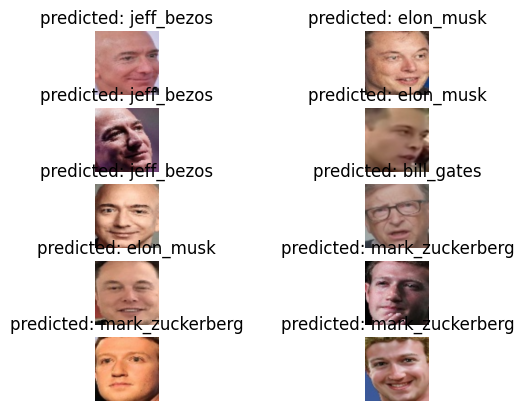

In [67]:
visualize_model(traine)
plt.show()

Вроде все подписаны корректно.

## Вывод

Предобученный resnet34 без заморозки слоев и прочей тонкой настройки смог довольно хорошо справиться с нашей задачей, выдав на валидационной выборке 98%-ю точность через 10 эпох обучения.